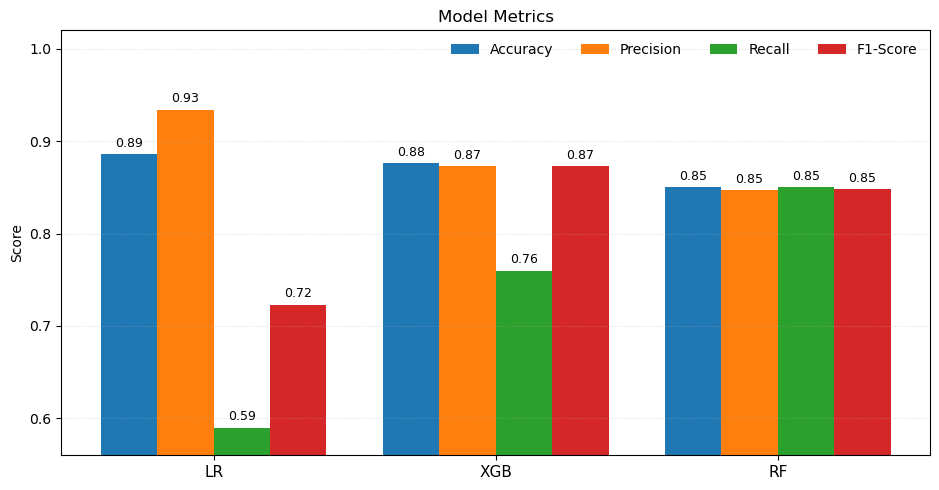

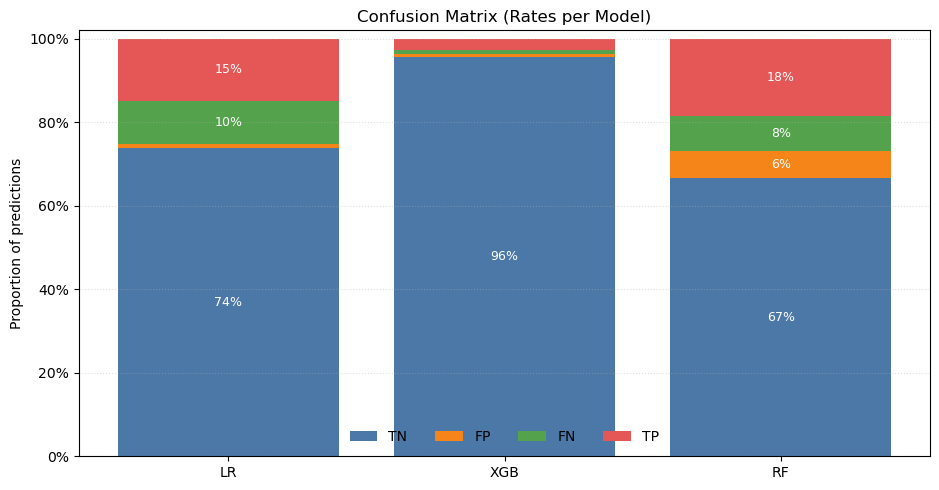

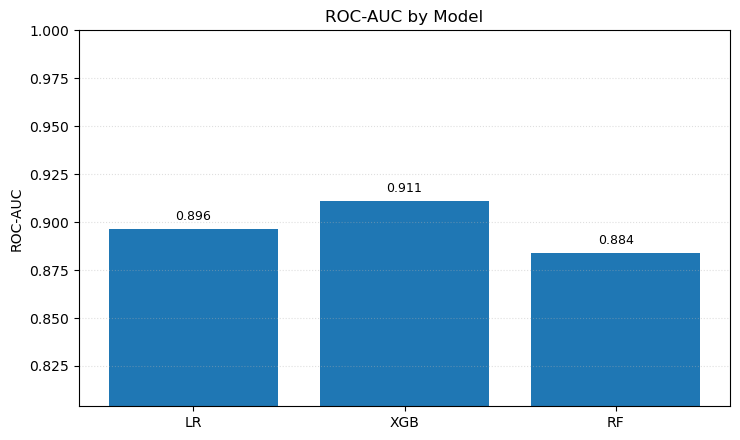


=== MODEL PERFORMANCE SUMMARY ===
Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC       TN    FP     FN     TP
   LR     0.886      0.934    0.59     0.723    0.896  1247105 17804 174891 251524
  XGB     0.876      0.873    0.76     0.873    0.911 10111202 69356 114314 283366
   RF     0.850      0.847    0.85     0.848    0.884   984687 95871 124975 272705


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,TN,FP,FN,TP
0,LR,0.886,0.934,0.590,0.723,0.896,1247105,17804,174891,251524
1,XGB,0.876,0.873,0.760,0.873,0.911,10111202,69356,114314,283366
2,RF,0.850,0.847,0.850,0.848,0.884,984687,95871,124975,272705


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "/Users/reesemullen/Downloads/model_outputs.csv"  
SAVE_DIR = ""                                                
DPI = 150

def maybe_save(fig, name):
    """Save a figure if SAVE_DIR is set, otherwise just show it."""
    if SAVE_DIR:
        os.makedirs(SAVE_DIR, exist_ok=True)
        path = os.path.join(SAVE_DIR, name)
        fig.savefig(path, dpi=DPI, bbox_inches="tight")
        print(f"saved: {path}")

# load
df = pd.read_csv(CSV_PATH)


# 1) Grouped metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
mdf = df[["Model"] + metrics].copy().set_index("Model")
x = np.arange(len(mdf.index))
width = 0.2

fig1, ax1 = plt.subplots(figsize=(9.5, 5))
for i, m in enumerate(metrics):
    bars = ax1.bar(x + (i - 1.5) * width, mdf[m].values, width, label=m)
    # small value labels above bars
    for b in bars:
        ax1.text(
            b.get_x() + b.get_width() / 2,
            b.get_height() + 0.005,
            f"{b.get_height():.2f}",
            ha="center", va="bottom", fontsize=9
        )

ax1.set_xticks(x)
ax1.set_xticklabels(mdf.index, fontsize=11)
lo = max(0.55, float(mdf.min().min()) - 0.03)
ax1.set_ylim(lo, 1.02)
ax1.set_ylabel("Score")
ax1.set_title("Model metrics")
ax1.legend(ncols=4, frameon=False)
ax1.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout()
maybe_save(fig1, "metrics_grouped_tight.png")
plt.show()


# 2) Confusion matrix
conf_cols = ["TN", "FP", "FN", "TP"]
cdf = df[["Model"] + conf_cols].copy().set_index("Model")
tot = cdf.sum(axis=1).replace(0, np.nan)
rates = (cdf.T / tot).T  # each row sums to 1

fig2, ax2 = plt.subplots(figsize=(9.5, 5))
bottom = np.zeros(len(rates))
colors = {"TN": "#4c78a8", "FP": "#f58518", "FN": "#54a24b", "TP": "#e45756"}
for c in conf_cols:
    ax2.bar(rates.index, rates[c].values, bottom=bottom, label=c, color=colors.get(c, None))
    bottom += rates[c].values

ax2.set_ylabel("Proportion of predictions")
ax2.set_title("Confusion matrix (rates by model)")
ax2.set_ylim(0, 1.02)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))
ax2.legend(ncols=4, frameon=False)
ax2.grid(axis="y", linestyle=":", alpha=0.4)

for i, model in enumerate(rates.index):
    cum = 0.0
    for c in conf_cols:
        h = rates.loc[model, c]
        if h > 0.05:
            ax2.text(i, cum + h / 2, f"{h:.0%}", ha="center", va="center", fontsize=9, color="white")
        cum += h

plt.tight_layout()
maybe_save(fig2, "confusion_rates_stacked.png")
plt.show()


# 3) ROC–AUC
if "ROC-AUC" in df.columns and df["ROC-AUC"].notna().any():
    r = df[["Model", "ROC-AUC"]].dropna()
    if not r.empty:
        fig3, ax3 = plt.subplots(figsize=(7.5, 4.5))
        bars = ax3.bar(r["Model"], r["ROC-AUC"])
        for b in bars:
            ax3.text(
                b.get_x() + b.get_width() / 2,
                b.get_height() + 0.003,
                f"{b.get_height():.3f}",
                ha="center", va="bottom", fontsize=9
            )
        lo = max(0.70, float(r["ROC-AUC"].min()) - 0.08)
        ax3.set_ylim(lo, 1.0)
        ax3.set_ylabel("ROC–AUC")
        ax3.set_title("ROC–AUC by model")
        ax3.grid(axis="y", linestyle=":", alpha=0.4)
        plt.tight_layout()
        maybe_save(fig3, "roc_auc_tight.png")
        plt.show()


# 4) Summary table

summary_cols = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "TN", "FP", "FN", "TP"]
present_cols = [c for c in summary_cols if c in df.columns]

summary = df[present_cols].copy().round(3)

print("\nModel performance summary\n")
print(summary.to_string(index=False))


try:
    from IPython.display import display
    styled = (
        summary.style
        .set_caption("Model performance summary")
        .background_gradient(subset=["Accuracy", "Precision", "Recall", "F1-Score"], cmap="Greens")
        .format(precision=3)
    )
    display(styled)
except Exception:
    pass
